In [1]:
# import packages
from matplotlib import rcParams
rcParams['figure.dpi'] = 120
rcParams["savefig.dpi"] = 140
rcParams['figure.facecolor'] = 'w'

from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import os
from lmfit import Model

import warnings
warnings.filterwarnings('ignore')

# path joining version for other paths
notebook_path = os.path.abspath('h3p.ipynb')
filepath = os.path.join(os.path.dirname(notebook_path), '02jun17/spec/')

# count number of fits files in folder
filesize = len([name for name in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, name))])

# load fits data
nirspec7_data = []

start_nirspec7 = 22 # fits index start, min >= 1, max <= n
end_nirspec7 = 112 # fits index end, min >= n, max <= 999

# order36
for i in range(filesize):
    n = i + start_nirspec7
    if n>= start_nirspec7 and n < 10:
        hdu_data = fits.getdata(filepath + 'order36/test/' + 'jun02s000' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n>= 10 and n < 100:
        hdu_data = fits.getdata(filepath + 'order36/test/' + 'jun02s00' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n >= 100 and n < end_nirspec7: # fits index ends at 111
        hdu_data = fits.getdata(filepath + 'order36/test/' + 'jun02s0' + '{}_order36.fits'.format(n), ext=0)
        nirspec7_data.append(hdu_data)
    elif n >= end_nirspec7:
        break
nirspec7_data_array = np.array(nirspec7_data)

# load waverange
waverange = fits.open(filepath + 'order36/' + 'waverange.fits', ignore_missing_end=True)[0].data

# obtain average flat field
average_flat_field = np.mean((nirspec7_data_array[32-start_nirspec7], 
                              nirspec7_data_array[33-start_nirspec7], 
                              nirspec7_data_array[34-start_nirspec7], 
                              nirspec7_data_array[35-start_nirspec7], 
                              nirspec7_data_array[36-start_nirspec7], 
                              nirspec7_data_array[37-start_nirspec7], 
                              nirspec7_data_array[38-start_nirspec7], 
                              nirspec7_data_array[39-start_nirspec7], 
                              nirspec7_data_array[40-start_nirspec7], 
                              nirspec7_data_array[41-start_nirspec7],), axis=0)


# obtain average flat lamp off
average_flat_lamp_off = np.mean((nirspec7_data_array[22-start_nirspec7], 
                                 nirspec7_data_array[23-start_nirspec7], 
                                 nirspec7_data_array[24-start_nirspec7],
                                 nirspec7_data_array[25-start_nirspec7], 
                                 nirspec7_data_array[26-start_nirspec7], 
                                 nirspec7_data_array[27-start_nirspec7], 
                                 nirspec7_data_array[28-start_nirspec7], 
                                 nirspec7_data_array[29-start_nirspec7], 
                                 nirspec7_data_array[30-start_nirspec7], 
                                 nirspec7_data_array[31-start_nirspec7],), axis=0)

# convert observation time (UTC) to seconds 
def fits_header_utc_to_second(fn):
    # fn = frame_number
    if fn >= start_nirspec7 and fn < 10:
        hdu_header = fits.open(filepath + 'jun02s000' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= 10 and fn < 100:
        hdu_header = fits.open(filepath + 'jun02s00' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= 100 and fn < end_nirspec7:
        hdu_header = fits.open(filepath + 'jun02s0' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= end_nirspec7:
        pass
    
    h = float(hdu_header['UTC'].split(':')[0])
    m = float(hdu_header['UTC'].split(':')[1])
    s = float(hdu_header['UTC'].split(':')[2])
    
    seconds = h * 3600 + m * 60 + s
    return seconds

# scale the sky frame using the equation on page 9 of Stallard_et_al_2019
def scale_sky_frame(fn_spec):
    """
    confirmed sky frames: 51, 59, 60, 72, 78, 79, 91, 103
    """
    if fn_spec > 51 and fn_spec < 59:
        fn_sky1 = 51 # frame number of sky1
        fn_sky2 = 59 # frame number of sky2
    elif fn_spec > 60 and fn_spec < 72:
        fn_sky1 = 60
        fn_sky2 = 72
    elif fn_spec > 72 and fn_spec < 78:
        fn_sky1 = 72
        fn_sky2 = 78
    elif fn_spec > 78 and fn_spec < 91:
        fn_sky1 = 79
        fn_sky2 = 91
    elif fn_spec > 91 and fn_spec < 103:
        fn_sky1 = 91
        fn_sky2 = 103

    sky1 = nirspec7_data_array[fn_sky1-start_nirspec7]
    sky2 = nirspec7_data_array[fn_sky2-start_nirspec7]

    t1 = fits_header_utc_to_second(fn_sky1) 
    t2 = fits_header_utc_to_second(fn_sky2)
    td = fits_header_utc_to_second(fn_spec)

    sky_final = sky1 * ((t2 - td) / (t2 - t1)) + sky2 * ((td - t1) / (t2 - t1))
    return sky_final

fn_spec = 97 # frame number of target spectra
sky_total = scale_sky_frame(fn_spec)

# remove sky background: (object - sky_frame)/(average_flat_field - average_flat_lamp_off)
sky_subtracted = (nirspec7_data_array[fn_spec-start_nirspec7] - sky_total) / (average_flat_field - average_flat_lamp_off)
#sky_subtracted[sky_subtracted>0.2] = 0.2
pixel = np.linspace(0, np.size(sky_subtracted, 1), np.size(sky_subtracted, 1))

# show reduced fits
plt.figure(figsize=(12,6))
plt.imshow(sky_subtracted, cmap='gist_gray')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()
#plt.xlim(50,150)
#plt.ylim(40,130)
plt.colorbar(orientation='horizontal', pad=0.1)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/RuoyanWang/Documents/LEICESTER/h3p/Trihydrogen-Cation/02jun17/spec/'

In [3]:
a = np.delete(sky_subtracted, np.s_[200:1024], 1)
b = np.delete(a, np.s_[0:85], 1)
c = np.delete(b, np.s_[28:120], 1)
pixel = np.linspace(0, np.size(c, 1), np.size(c, 1))
plt.figure(figsize=(12,6))
plt.imshow(c, cmap='gist_gray')
plt.xlabel('Wavelength Axis')
plt.ylabel('Spatial Axis')
plt.gca().invert_yaxis()
#plt.xlim(1000,1005)

In [4]:
ind = 38
plt.plot(c[ind])

In [5]:
upper_h2 = 137
lower_h2 = 37
for i in range(lower_h2, upper_h2):
    if i >= 90 and i < upper_h2:
        # create lmfit model with defined gaussian
        h2_model = Model(gaussian_fit)

        # create parameters and add initial guess
        h2_params = h2_model.make_params()
        h2_params.add('a0', value=0.03)
        h2_params.add('a1', value=11)
        h2_params.add('a2', value=2)
        h2_params.add('a3', value=0)
        h2_params.add('a4', value=0)
        h2_params.add('a5', value=0)
    
        try:
            h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
        except:
            print('Error occured at i=' + str(i))
        #print(h2_fit_result.fit_report())
        plt.figure()
        plt.title('i='+str(i))
        plt.plot(pixel, c[i])
        plt.plot(pixel, h2_fit_result.best_fit, 'r-', label='best fit')
    
    if i >= 60 and i < 90:
        # create lmfit model with defined gaussian
        h2_model = Model(gaussian_fit)

        # create parameters and add initial guess
        h2_params = h2_model.make_params()
        h2_params.add('a0', value=0.02)
        h2_params.add('a1', value=15)
        h2_params.add('a2', value=2)
        h2_params.add('a3', value=0)
        h2_params.add('a4', value=0)
        h2_params.add('a5', value=0)
        
        try:
            h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
        except:
            print('Error occured at i=' + str(i))
        #print(h2_fit_result.fit_report())
        plt.figure()
        plt.title('i='+str(i))
        plt.plot(pixel, c[i])
        plt.plot(pixel, h2_fit_result.best_fit, 'r-', label='best fit')
    
    if i >= lower_h2 and i < 60:
        # create lmfit model with defined gaussian
        h2_model = Model(gaussian_fit)

        # create parameters and add initial guess
        h2_params = h2_model.make_params()
        h2_params.add('a0', value=0.02)
        h2_params.add('a1', value=17)
        h2_params.add('a2', value=2.5)
        h2_params.add('a3', value=0)
        h2_params.add('a4', value=0)
        h2_params.add('a5', value=0)
        
        try:
            h2_fit_result = h2_model.fit(c[i], h2_params, x=pixel)
        except:
            print('Error occured at i=' + str(i))
        #print(h2_fit_result.fit_report())
        plt.figure()
        plt.title('i='+str(i))
        plt.plot(pixel, c[i])
        plt.plot(pixel, h2_fit_result.best_fit, 'r-', label='best fit')

array([[0.785, 0.822, 0.859, ..., 9.702, 9.739, 9.776],
       [0.785, 0.822, 0.859, ..., 9.702, 9.739, 9.776],
       [0.785, 0.822, 0.859, ..., 9.702, 9.739, 9.776],
       ...,
       [0.785, 0.822, 0.859, ..., 9.702, 9.739, 9.776],
       [0.785, 0.822, 0.859, ..., 9.702, 9.739, 9.776],
       [0.785, 0.822, 0.859, ..., 9.702, 9.739, 9.776]])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


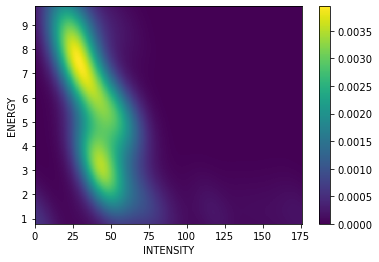

In [122]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import kde
 
# create data
x = intensity_array_0_to_9[0]
y = energy_array_0_to_9[0]
 
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins=500
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape))
plt.colorbar()
plt.xlabel('INTENSITY')
plt.ylabel('ENERGY')
plt.show()

In [ ]:
kde.gaussian_kernel_estimate

In [265]:
energy_array_0_to_9.shape

(10, 244)

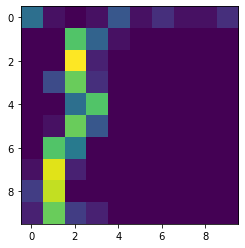

In [263]:
plt.imshow(np.histogram2d(energy_array_0_to_9[0], intensity_array_0_to_9[0])[0])

TypeError: Dimensions of C (10, 244) are incompatible with X (244) and/or Y (244); see help(pcolormesh)

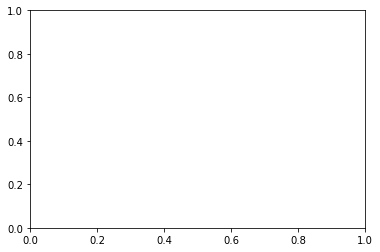

In [46]:
# Sample data
side = np.linspace(-2,2,15)
x,y = np.meshgrid(time,energy_array_0_to_9[0])
z = intensity_array_0_to_9#np.exp(-((X-1)**2+Y**2))

# Plot the density map using nearest-neighbor interpolation
plt.pcolormesh(x,y,z)
plt.show()

In [60]:
intensity_array_0_to_9

array([[ 1.,  0.,  0., ..., 23., 12., 26.],
       [ 0.,  0.,  0., ..., 40., 17., 21.],
       [ 0.,  0.,  0., ..., 25., 29., 18.],
       ...,
       [ 0.,  0.,  1., ..., 24., 37., 24.],
       [ 0.,  0.,  0., ..., 27., 22., 25.],
       [ 0.,  0.,  0., ..., 29., 43., 28.]])

In [61]:
np.swapaxes(intensity_array_0_to_9,0,1)

array([[ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       ...,
       [23., 40., 25., ..., 24., 27., 29.],
       [12., 17., 29., ..., 37., 22., 43.],
       [26., 21., 18., ..., 24., 25., 28.]])

TypeError: Dimensions of C (244, 10) are incompatible with X (244) and/or Y (244); see help(pcolormesh)

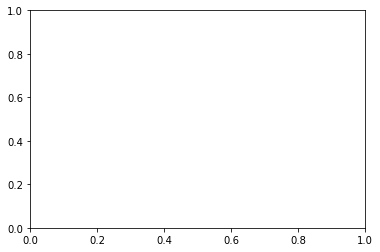

In [62]:
np.random.seed(19680801)
Z = intensity_array_0_to_9
x = np.arange(-0.5, 10, 1)  # len = 11
y = np.arange(4.5, 11, 1)  # len = 7

fig, ax = plt.subplots()
ax.pcolormesh(time, energy_array_0_to_9[0], np.swapaxes(intensity_array_0_to_9,0,1))

In [83]:
time

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [82]:
energy_array_0_to_9[0]

array([0.785, 0.822, 0.859, 0.896, 0.933, 0.97 , 1.007, 1.044, 1.081,
       1.118, 1.155, 1.192, 1.229, 1.266, 1.303, 1.34 , 1.377, 1.414,
       1.451, 1.488, 1.525, 1.562, 1.599, 1.636, 1.673, 1.71 , 1.747,
       1.784, 1.821, 1.858, 1.895, 1.932, 1.969, 2.006, 2.043, 2.08 ,
       2.117, 2.154, 2.191, 2.228, 2.265, 2.302, 2.339, 2.376, 2.413,
       2.45 , 2.487, 2.524, 2.561, 2.598, 2.635, 2.672, 2.709, 2.746,
       2.783, 2.82 , 2.857, 2.894, 2.931, 2.968, 3.005, 3.042, 3.079,
       3.116, 3.153, 3.19 , 3.227, 3.264, 3.301, 3.338, 3.375, 3.412,
       3.449, 3.486, 3.523, 3.56 , 3.597, 3.634, 3.671, 3.708, 3.745,
       3.782, 3.819, 3.856, 3.893, 3.93 , 3.967, 4.004, 4.041, 4.078,
       4.115, 4.152, 4.189, 4.226, 4.263, 4.3  , 4.337, 4.374, 4.411,
       4.448, 4.485, 4.522, 4.559, 4.596, 4.633, 4.67 , 4.707, 4.744,
       4.781, 4.818, 4.855, 4.892, 4.929, 4.966, 5.003, 5.04 , 5.077,
       5.114, 5.151, 5.188, 5.225, 5.262, 5.299, 5.336, 5.373, 5.41 ,
       5.447, 5.484,

In [88]:
intensity_array_0_to_9[0]

array([  1.,   0.,   0.,   0.,   1.,   0.,   3.,   1.,  31., 117., 176.,
       176., 152., 164., 120., 138.,  95., 116.,  78.,  77.,  77.,  85.,
        76.,  64.,  72.,  68.,  77.,  69.,  50.,  63.,  62.,  49.,  62.,
        49.,  43.,  51.,  64.,  58.,  45.,  46.,  51.,  51.,  44.,  44.,
        45.,  49.,  45.,  49.,  43.,  41.,  45.,  45.,  45.,  42.,  52.,
        37.,  49.,  46.,  38.,  40.,  41.,  60.,  44.,  46.,  48.,  46.,
        37.,  38.,  59.,  42.,  41.,  43.,  47.,  41.,  50.,  39.,  43.,
        41.,  35.,  44.,  35.,  43.,  38.,  41.,  35.,  44.,  55.,  32.,
        35.,  55.,  40.,  36.,  45.,  39.,  37.,  39.,  55.,  42.,  49.,
        44.,  45.,  60.,  44.,  56.,  46.,  56.,  48.,  57.,  60.,  48.,
        46.,  59.,  55.,  68.,  59.,  54.,  53.,  64.,  57.,  56.,  56.,
        62.,  63.,  66.,  47.,  52.,  52.,  58.,  41.,  54.,  48.,  49.,
        57.,  49.,  40.,  55.,  43.,  36.,  32.,  48.,  47.,  41.,  46.,
        40.,  46.,  37.,  34.,  33.,  36.,  29.,  4

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


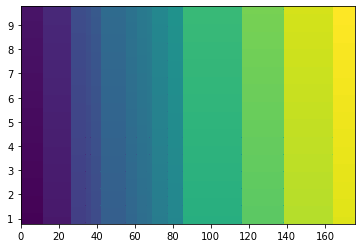

In [89]:
# Sample data
X,Y = np.meshgrid(intensity_array_0_to_9[0],energy_array_0_to_9[0])
Z = X+Y

# Plot the density map using nearest-neighbor interpolation
plt.pcolormesh(X,Y,Z)
plt.show()

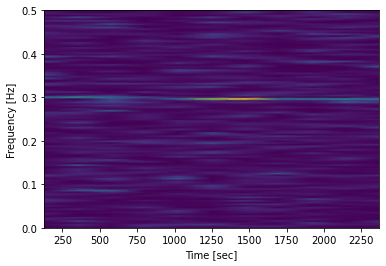

In [113]:
from scipy import signal

fs = 10e3
N = 2560
amp = 2 * np.sqrt(2)
noise_power = 0.01 * fs / 2
time = np.arange(N) / float(fs)
mod = 500*np.cos(2*np.pi*0.25*time)
carrier = amp * np.sin(2*np.pi*3e3*time + mod)
noise = np.random.normal(scale=np.sqrt(noise_power), size=time.shape)
noise *= np.exp(-time/5)
x = carrier + noise

f, t, Sxx = signal.spectrogram(x)
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [109]:
len(x)

1000

In [103]:
energy_array_0_to_9[0]

array([0.785, 0.822, 0.859, 0.896, 0.933, 0.97 , 1.007, 1.044, 1.081,
       1.118, 1.155, 1.192, 1.229, 1.266, 1.303, 1.34 , 1.377, 1.414,
       1.451, 1.488, 1.525, 1.562, 1.599, 1.636, 1.673, 1.71 , 1.747,
       1.784, 1.821, 1.858, 1.895, 1.932, 1.969, 2.006, 2.043, 2.08 ,
       2.117, 2.154, 2.191, 2.228, 2.265, 2.302, 2.339, 2.376, 2.413,
       2.45 , 2.487, 2.524, 2.561, 2.598, 2.635, 2.672, 2.709, 2.746,
       2.783, 2.82 , 2.857, 2.894, 2.931, 2.968, 3.005, 3.042, 3.079,
       3.116, 3.153, 3.19 , 3.227, 3.264, 3.301, 3.338, 3.375, 3.412,
       3.449, 3.486, 3.523, 3.56 , 3.597, 3.634, 3.671, 3.708, 3.745,
       3.782, 3.819, 3.856, 3.893, 3.93 , 3.967, 4.004, 4.041, 4.078,
       4.115, 4.152, 4.189, 4.226, 4.263, 4.3  , 4.337, 4.374, 4.411,
       4.448, 4.485, 4.522, 4.559, 4.596, 4.633, 4.67 , 4.707, 4.744,
       4.781, 4.818, 4.855, 4.892, 4.929, 4.966, 5.003, 5.04 , 5.077,
       5.114, 5.151, 5.188, 5.225, 5.262, 5.299, 5.336, 5.373, 5.41 ,
       5.447, 5.484,

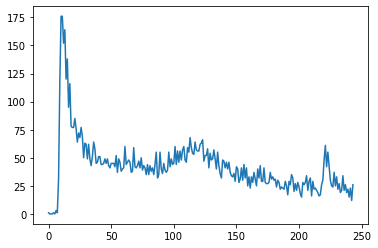

In [97]:
plt.plot(intensity_array_0_to_9[0])

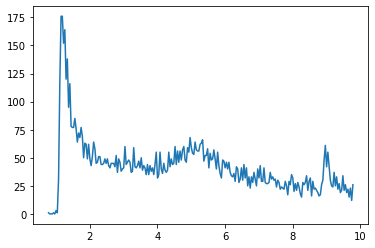

In [99]:
plt.plot(energy_array_0_to_9[0], intensity_array_0_to_9[0])